# Dependências 

In [75]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from glob import glob
from os.path import basename
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, LSTM, Dropout, Embedding
from keras.models import Sequential

pd.options.display.max_columns = None
%matplotlib inline

In [3]:
COLS_SCOUTS_DEF = ['CA','CV','DD','DP','FC','GC','GS','RB','SG'] # alphabetical order
COLS_SCOUTS_ATK = ['A','FD','FF','FS','FT','G','I','PE','PP'] # alphabetical order
COLS_SCOUTS = COLS_SCOUTS_DEF + COLS_SCOUTS_ATK

COLS_STATISTICS = ['atletas.pontos_num', 'atletas.preco_num', 'atletas.variacao_num', 'atletas.media_num']
COLS_ATHLETES_INFO = ['atletas.atleta_id', 'atletas.apelido', 'atletas.posicao_id', 'atletas.clube.id.full.name', 'atletas.status_id']

COL_ID = 'atletas.atleta_id'
COL_ROUND = 'atletas.rodada_id'
COL_POINTS = 'atletas.pontos_num'
COL_POSITION = 'atletas.posicao_id'
COL_STATUS = 'atletas.status_id'
COL_TEAM_ID = 'atletas.clube.id.full.name'
COL_NICKNAME = 'atletas.apelido'

COLS_ALL = [COL_ROUND] + COLS_ATHLETES_INFO + COLS_STATISTICS + COLS_SCOUTS

# Análise dos Dados 

In [4]:
def import_data(folder_year):
    list_files = glob(folder_year + 'rodada-*.csv')
    df_data = pd.DataFrame([])
    
    for file in list_files:
        df_round = pd.read_csv(file, index_col=0)
        print('Importando {} linhas do arquivo {}'.format(df_round.shape[0], basename(file)))
        df_data = df_data.append(df_round, sort=False)
    return df_data

In [5]:
df = import_data('../../data/2019/')
df = df[COLS_ALL]
print(df.shape)

df.describe()

Importando 740 linhas do arquivo rodada-1.csv
Importando 738 linhas do arquivo rodada-2.csv
Importando 739 linhas do arquivo rodada-3.csv
Importando 739 linhas do arquivo rodada-4.csv
Importando 771 linhas do arquivo rodada-5.csv
(3727, 28)


,atletas.rodada_id,atletas.atleta_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
count,3727.000000,3727.000000,3727.000000,3727.000000,3727.000000,3727.000000,462.000000,28.0,106.000000,11.0,1265.000000,9.000000,112.000000,1236.000000,272.000000,213.000000,626.000000,808.000000,1263.000000,76.000000,296.000000,247.000000,1475.000000,13.0
mean,3.016904,83036.696807,1.141527,4.991825,0.000405,1.377902,1.207792,1.0,4.556604,1.0,3.067984,1.111111,3.562500,3.322816,1.202206,1.117371,1.629393,1.831683,2.836105,1.065789,1.209459,1.307692,4.495593,1.0
std,1.420645,18867.676702,2.886747,3.656104,1.194524,2.573264,0.479633,0.0,3.070847,0.0,2.365722,0.333333,1.759306,2.739159,0.454086,0.376589,1.038475,1.213875,2.336419,0.249561,0.469452,0.676599,3.449453,0.0
min,1.000000,36886.000000,-9.000000,0.690000,-9.310000,-9.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,2.000000,71709.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.0
50%,3.000000,86842.000000,0.000000,4.000000,0.000000,0.000000,1.000000,1.0,4.500000,1.0,2.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.0
75%,4.000000,98888.000000,0.900000,6.660000,0.000000,2.400000,1.000000,1.0,6.000000,1.0,4.000000,1.000000,5.000000,4.000000,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,1.000000,6.000000,1.0
max,5.000000,105647.000000,23.200000,23.620000,14.520000,22.700000,3.000000,1.0,14.000000,1.0,22.000000,2.000000,8.000000,25.000000,3.000000,3.000000,7.000000,8.000000,16.000000,2.000000,3.000000,7.000000,21.000000,1.0


In [6]:
pandas_profiling.ProfileReport(df)

Number of variables,29
Number of observations,3727
Total Missing (%),54.2%
Total size in memory,844.5 KiB
Average record size in memory,232.0 B
Numeric,22
Categorical,4
Boolean,3
Date,0
Text (Unique),0
Rejected,0


In [7]:
print("Dimensões originais dos dados: ", df.shape)

# remove todas as linhas cujo scouts são NANs 
df_clean = df.dropna(how='all', subset=COLS_SCOUTS)
print('qtde. de jogadores com scouts: ', df_clean.shape[0])

# remove técnicos
df_clean = df_clean[df_clean[COL_POSITION] != "tec"]
print("qtde. de linhas com posições válidas: ", df_clean.shape[0])

# altera os Status == 'Nulo' para 'Provável'
df_clean.loc[df_clean[COL_STATUS] == 'Nulo', COL_STATUS] = 'Provável'

# preenche scouts NANs com zero
df_clean[COLS_SCOUTS] = df_clean[COLS_SCOUTS].fillna(value=0)

print("Dimensão dos dados após as limpezas: ", df_clean.shape)
df_clean.head(10)

# checa se ainda existem valores nulos
assert(~df_clean.isnull().any().any())

df_clean.describe()

Dimensões originais dos dados:  (3727, 28)
qtde. de jogadores com scouts:  1746
qtde. de linhas com posições válidas:  1746
Dimensão dos dados após as limpezas:  (1746, 28)


,atletas.rodada_id,atletas.atleta_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
count,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,3.234822,77336.365407,2.234364,6.571025,0.001237,2.740819,0.319588,0.016037,0.276632,0.006300,2.222795,0.005727,0.228522,2.352234,0.187285,0.136312,0.584192,0.847652,2.051546,0.046392,0.205040,0.184994,3.797824,0.007446
std,1.375121,19091.681741,3.827333,4.004129,1.721938,3.138650,0.587194,0.125652,1.323663,0.079146,2.435922,0.082728,0.979392,2.755809,0.471392,0.388634,0.998602,1.231272,2.357620,0.223597,0.493276,0.521869,3.564038,0.085991
min,1.000000,37604.000000,-9.000000,0.690000,-9.310000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,68800.000000,0.000000,3.660000,-0.740000,0.762500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.000000,80363.000000,0.700000,5.595000,0.000000,2.280000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,4.000000,92496.000000,3.800000,8.607500,0.390000,4.427500,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,6.000000,0.000000
max,5.000000,105553.000000,23.200000,23.620000,14.520000,22.700000,3.000000,1.000000,14.000000,1.000000,22.000000,2.000000,8.000000,25.000000,3.000000,3.000000,7.000000,8.000000,16.000000,2.000000,3.000000,7.000000,21.000000,1.000000


[1 2 3 4 5] [254 313 366 395 418]


<BarContainer object of 5 artists>

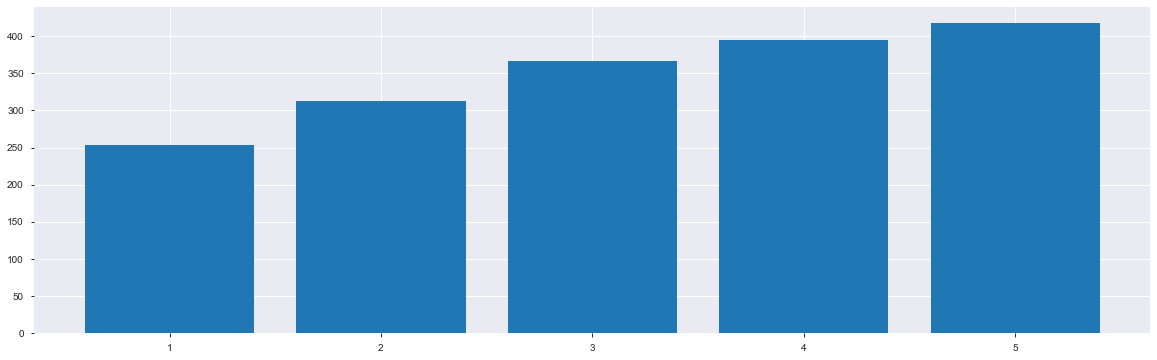

In [10]:
unique, counts = np.unique(df_clean[COL_ROUND].values, return_counts=True)
print(unique, counts)

plt.figure(figsize=(20, 6))
plt.bar(unique, counts)

# Criação das Amostras

In [62]:
def create_samples(df, cols_of_interest, from_round=1, to_round=None, last_rounds=None, return_pred=True):
    players = list(df[COL_ID].unique())
    rounds = list(df[COL_ROUND].unique())
    n_rounds = max(rounds)
    n_players = len(players)
    to_round = n_rounds if to_round is None else to_round
    last_rounds = n_rounds - 1 if last_rounds is None else last_rounds
    
    list_rounds = np.array([list(range(1, n_rounds+1))  for _ in range(n_players)]).flatten()
    list_players = np.array([[player] * n_rounds for player in players]).flatten()
    df_all = pd.DataFrame([[p, r] for p, r in zip(list_players, list_rounds)], columns=[COL_ID, COL_ROUND])
    
    df_merge = df_all.merge(df, how='left', on=[COL_ID, COL_ROUND])
    df_merge.fillna(value=0, inplace=True)
    
    x, y = [], []
    for r in range(from_round, to_round - last_rounds + 1):
        print('x: rodadas de {:}-{:} y: rodada {}'.format(r, r + last_rounds - 1, r + last_rounds))
        
        df_round = df_merge[(df_merge[COL_ROUND] >= r) & (df_merge[COL_ROUND] < r + last_rounds)]
        df_group = df_round.groupby(by=[COL_ID], as_index=False, sort=False)
        x.append([data[cols_of_interest].values for _, data in df_group])
            
        df_ids = pd.DataFrame([data[COL_ID].values[0] for _, data in df_group], columns=[COL_ID])
        if return_pred:
            df_next = df_merge[df_merge[COL_ROUND] == r + last_rounds]
            assert(np.all(df_ids[COL_ID].values ==  df_next[COL_ID].values))

            df_points = df_ids.merge(df_next, how='left', on=[COL_ID])[COL_POINTS]
            y.append(df_points.fillna(value=0).values)
        
    return np.concatenate([r for r in x]), np.array(y).flatten() if return_pred else df_ids[COL_ID].values

In [63]:
df_samples = pd.get_dummies(df_clean, columns=[COL_POSITION, COL_TEAM_ID], prefix=['pos', 'clube'])
print(df_samples.shape)
df_samples.head()

(1746, 50)


,atletas.rodada_id,atletas.atleta_id,atletas.apelido,atletas.status_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP,pos_ata,pos_gol,pos_lat,pos_mei,pos_zag,clube_Athlético-PR,clube_Atlético-MG,clube_Avaí,clube_Bahia,clube_Botafogo,clube_CSA,clube_Ceará,clube_Chapecoense,clube_Corinthians,clube_Cruzeiro,clube_Flamengo,clube_Fluminense,clube_Fortaleza,clube_Goiás,clube_Grêmio,clube_Internacional,clube_Santos,clube_São Paulo,clube_Vasco
1,1,80196,Yago Pikachu,Provável,2.0,11.10,-2.90,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,1,78445,Renê,Provável,0.6,8.74,-3.26,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,1,80853,Pedro Geromel,Provável,8.0,12.49,2.49,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10,1,38229,Fábio Santos,Provável,9.4,12.77,3.77,9.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,38910,Ricardo Oliveira,Provável,12.3,18.94,3.94,12.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
cols_of_interest = df_samples.columns.drop([COL_ROUND, COL_ID, COL_NICKNAME, COL_STATUS])
cols_of_interest

Index(['atletas.pontos_num', 'atletas.preco_num', 'atletas.variacao_num',
       'atletas.media_num', 'CA', 'CV', 'DD', 'DP', 'FC', 'GC', 'GS', 'RB',
       'SG', 'A', 'FD', 'FF', 'FS', 'FT', 'G', 'I', 'PE', 'PP', 'pos_ata',
       'pos_gol', 'pos_lat', 'pos_mei', 'pos_zag', 'clube_Athlético-PR',
       'clube_Atlético-MG', 'clube_Avaí', 'clube_Bahia', 'clube_Botafogo',
       'clube_CSA', 'clube_Ceará', 'clube_Chapecoense', 'clube_Corinthians',
       'clube_Cruzeiro', 'clube_Flamengo', 'clube_Fluminense',
       'clube_Fortaleza', 'clube_Goiás', 'clube_Grêmio', 'clube_Internacional',
       'clube_Santos', 'clube_São Paulo', 'clube_Vasco'],
      dtype='object')

In [68]:
x, y = create_samples(df_samples, cols_of_interest, from_round=1, to_round=5, last_rounds=3)

print(x.shape, y.shape)

x: rodadas de 1-3 y: rodada 4
x: rodadas de 2-4 y: rodada 5
(844, 3, 46) (844,)


# Treinamento do Modelo

In [81]:
model = Sequential()
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=x.shape[1:]))
model.add(Dropout(rate=0.2))
model.add(Dense(units=64, activation='linear'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=16, return_sequences=False))
model.add(Dense(units=1, activation='linear'))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x, y, batch_size=32, epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 3, 256)            310272    
_________________________________________________________________
dropout_21 (Dropout)         (None, 3, 256)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 3, 64)             16448     
_________________________________________________________________
dropout_22 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 3, 16)             1040      
_________________________________________________________________
dropout_23 (Dropout)         (None, 3, 16)             0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 16)                2112      
__________

844/844 [==============================] - 1s 1ms/step - loss: 2.5597
Epoch 83/200
844/844 [==============================] - 1s 1ms/step - loss: 2.4910
Epoch 84/200
844/844 [==============================] - 1s 1ms/step - loss: 2.5352
Epoch 85/200
844/844 [==============================] - 1s 1ms/step - loss: 2.4684
Epoch 86/200
844/844 [==============================] - 1s 1ms/step - loss: 2.4497
Epoch 87/200
844/844 [==============================] - 1s 1ms/step - loss: 2.4480
Epoch 88/200
844/844 [==============================] - 1s 1ms/step - loss: 2.3351
Epoch 89/200
844/844 [==============================] - 1s 1ms/step - loss: 2.3385
Epoch 90/200
844/844 [==============================] - 1s 1ms/step - loss: 2.3156
Epoch 91/200
844/844 [==============================] - 1s 1ms/step - loss: 2.2003
Epoch 92/200
844/844 [==============================] - 1s 1ms/step - loss: 2.2700
Epoch 93/200
844/844 [==============================] - 1s 1ms/step - loss: 2.3346
Epoch 94/200
844/

844/844 [==============================] - 1s 1ms/step - loss: 1.5085
Epoch 180/200
844/844 [==============================] - 1s 1ms/step - loss: 1.4969
Epoch 181/200
844/844 [==============================] - 1s 1ms/step - loss: 1.6546
Epoch 182/200
844/844 [==============================] - 1s 1ms/step - loss: 1.5167
Epoch 183/200
844/844 [==============================] - 1s 1ms/step - loss: 1.5151
Epoch 184/200
844/844 [==============================] - 1s 1ms/step - loss: 1.5314
Epoch 185/200
844/844 [==============================] - 1s 1ms/step - loss: 1.4936
Epoch 186/200
844/844 [==============================] - 1s 2ms/step - loss: 1.4964
Epoch 187/200
844/844 [==============================] - 1s 2ms/step - loss: 1.5456
Epoch 188/200
844/844 [==============================] - 1s 1ms/step - loss: 1.5124
Epoch 189/200
844/844 [==============================] - 1s 1ms/step - loss: 1.4766
Epoch 190/200
844/844 [==============================] - 1s 1ms/step - loss: 1.4991
Epoch 

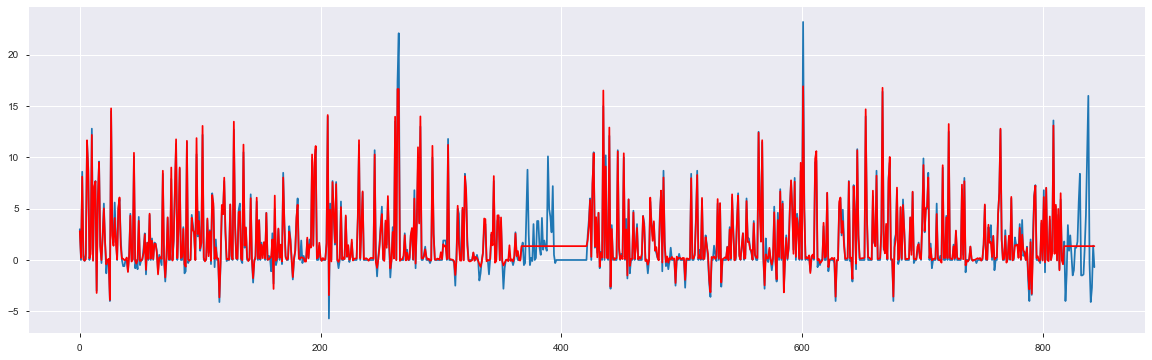

In [82]:
y_pred = model.predict(x)

plt.figure(figsize=(20, 6))
plt.plot(y)
plt.plot(y_pred, color='red')

# Predição de Jogadores

In [83]:
x_test, ids = create_samples(df_samples, cols_of_interest, from_round=2, to_round=5, last_rounds=3, return_pred=False)

print(x_test.shape, ids.shape)

x: rodadas de 2-4 y: rodada 5
(422, 3, 46) (422,)


In [84]:
y_next = model.predict(x_test)
sort_pos = np.argsort(y_next.flatten())
best_ids = ids[sort_pos[-10:]]

print(best_ids)

[ 78478  78577  70222  90285  73635  62104  68872  42234 100987  90458]


In [85]:
assert(np.all(df_samples[COL_ID].values == df_clean[COL_ID].values))

df_pred = df_clean[df_clean[COL_ID].isin(best_ids)].drop_duplicates(subset=COL_ID)
df_pred

,atletas.rodada_id,atletas.atleta_id,atletas.apelido,atletas.posicao_id,atletas.clube.id.full.name,atletas.status_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
24,1,42234,Cássio,gol,Corinthians,Provável,-4.5,5.20,-6.80,-4.5,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32,1,90285,Bruno Henrique,ata,Flamengo,Provável,21.0,21.51,11.51,21.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,0.0
401,1,78577,Ricardinho,mei,Ceará,Provável,0.3,4.37,-1.63,0.3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
405,1,78478,Willian Arão,mei,Flamengo,Provável,8.9,11.73,3.73,8.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
511,1,90458,Marcinho,ata,Fortaleza,Provável,-0.3,2.57,-1.43,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
662,1,68872,Marcelo Lomba,gol,Internacional,Provável,2.0,9.02,-1.98,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702,1,100987,Nonato,mei,Internacional,Provável,3.9,4.79,1.79,3.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0
570,2,62104,Robinho,mei,Cruzeiro,Provável,4.2,8.33,-0.67,4.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,6.0,0.0
432,3,70222,Sidão,gol,Vasco,Provável,-2.3,3.58,-2.42,-2.3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
515,4,73635,Rildo,ata,Chapecoense,Provável,1.3,4.78,-1.22,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0


In [86]:
y_next[sort_pos[-10:]]

array([[11.674912],
       [12.405226],
       [12.800242],
       [12.909614],
       [13.105286],
       [13.253189],
       [14.686717],
       [16.519358],
       [16.783813],
       [16.924988]], dtype=float32)